# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [7]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [8]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/"+name+"/history?period1="+str(init)+"&period2="+str(end)+"&interval=1d&filter=history&frequency=1d"
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [9]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-06-2018', 'end' : '20-06-2018'},
                  {'init' : '06-03-2018', 'end' : '30-05-2018'},
                  {'init' : '01-09-2017', 'end' : '05-03-2018'},
                  {'init' : '13-04-2017', 'end' : '31-08-2017'},
                  {'init' : '01-01-2017', 'end' : '12-04-2017'}]

stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [10]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [13]:
stock_prices_pd.head()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2017-01-02,16.31,33.53,23.82,14.66,25.06,16.0,7.41,44.08,27.82,22.71
2017-01-03,16.64,34.95,24.77,15.50,26.17,16.0,7.74,44.53,28.81,23.34
2017-01-04,16.51,35.10,24.76,15.50,25.70,16.0,7.78,44.35,29.72,23.01
2017-01-05,16.60,35.58,24.90,15.75,26.68,16.0,7.86,43.60,29.12,22.76
2017-01-06,16.46,35.70,25.09,15.66,25.97,16.0,7.83,43.71,28.67,22.81


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [11]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [12]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'Cardano' : 'cardano',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'IOTA' : 'iota',
              'EOS' : 'eos',
              'tether' : 'tether',
              'TRON' : 'tron',
              'dash' : 'dash'}

date_interval = {'init': '2017-01-01', 'end' : '2018-06-20' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [8]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd.head()

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,NaN,0.141841,0.002481,13.97,NaN,NaN,1.0,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,NaN,0.145642,0.002477,16.05,NaN,NaN,1.0,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,NaN,0.140422,0.002554,16.09,NaN,NaN,1.0,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,NaN,0.136734,0.002735,18.53,NaN,NaN,1.0,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,NaN,0.131070,0.002598,16.19,NaN,NaN,1.0,NaN,14.38


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

According to P. Morettin, the relative variance or the *simple liquidity return* $R_t$ of an asset is given by:

$$Rt = \frac{P_t - P_{t-1}}{P_{t-1}}$$


As $R_t$ is defined as the expected return of an asset, generally expressed as a percent value, $r_t$ however is defined as the *return rate* of an asset, given by:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Therefore, a simple return $R_t$ is obtained by: 

$$ R_t = {e^{r_t}} - 1 $$


The first term presented above $R_t$, is pretended to be used when the optimization takes place, while $r_t$ is the termo to be predicted with a GARCH model.

In [67]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

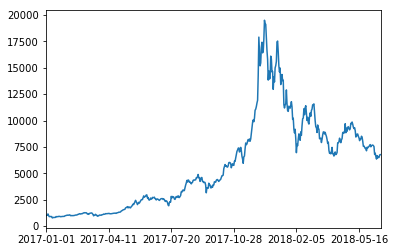

In [68]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

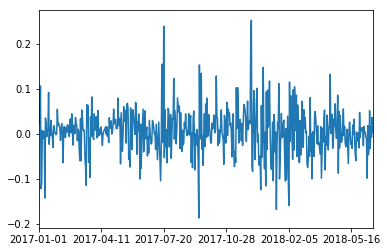

In [69]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

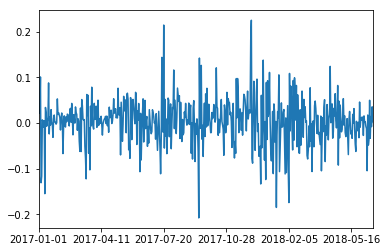

In [70]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

In [71]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,NaN,0.026798,-0.001612,0.14889,NaN,NaN,0.0,NaN,0.051647


In [72]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,NaN,0.026445,-0.001614,0.138797,NaN,NaN,0.0,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

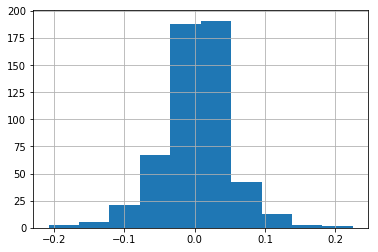

In [73]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [112]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccur_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: Some experts stand of the hyphothesis there is a weak negative correlation between criptocurrencies returns and stock market assets returns regarding FEAR index cotation, it means when there exists hihgher expeculation and fear in markets such as criptocurrencies, the subjective risk is transferred to stocked market.

It is showed in the heat map below with negative (although unexisting sometimes) correlation between the majority of cryptocurrencies and stocks.

In order to appreciate such phenomena, a heatmap showing correlations between all the assets considered is calculated.

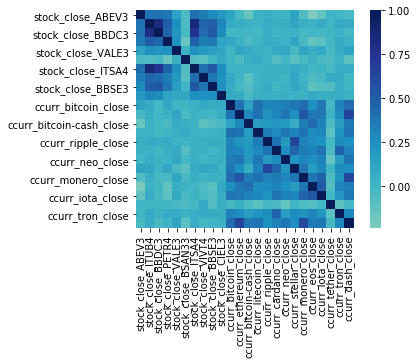

In [87]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

In [88]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 2, o_range = 0, q_range = 2, dist = "StudentsT"):
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {
                            'best_aic' : tmp_aic,
                            'results' : res
                        }
                except:
                    continue
    return dict_temp

#d = fit_garch(percent_returns_pd['ccurr_bitcoin-cash_close'])


In [89]:
test_returned = percent_stocks_returns.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
h.1,0.000477,0.000648,0.000577,0.001759,0.002485,0.000153,0.001249,0.000231,-0.000118,-0.000642


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [90]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
h.1,0.000477,0.000648,0.000577,0.001761,0.002488,0.000153,0.00125,0.000231,-0.000118,-0.000641


## Drawing Markowitz efficient frontier


Different from other proposals, this method will take advantage of the already simulated portafolios, trying to reach for the maximum return at each fixed risk value.

For this, it is supposed that the portfolio with the maximum return and te portafolio with the minimal risk belong to the Markowitz efficient frontier, furthermore these ones may allow us to determine the interval of risk values within the quoted frontier. 

### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [91]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == max(df['return'])]
    min_risk = df.loc[df['risk'] == min(df['risk'])]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### From the portfolios within Markowitz efficient frontier, Ratio Sharpe is the measure that will allow to pick the best one.

According to (EAFIT reference), the most known investement startegies are:

** The equal wiehgt strategy:** Is one of the most used strategy in portfolio diversification due its simplicity in implementation and understading. It simply weights every stock in a portfolio equally.

** Minimum variance strategy:** Based on Markoweitz portfolio optimizatoin model, from the optimizied portfolios set, the portafolio with the minimum value of variance is selected.

** Mean variance straegy:** Once the Markowitz efficient frontier is calculated, Ratio of Sharpe will lead to significant clues about what portfolio may be the best one when the investor does not have a clear idea about the level of risk he would tolerate.

As sawn since the beginning of this work, the model presented in this work includes the last two.

Once the Markowitz frotnier is drawn, an investor is capable to pick the risk he will tolerate considering the probable return the portfolio might offer. But in many cases, if not the most, evaluate in which level of risk is desired to operate could result difficult to do.

Therefore, the ratio of sharpe is introduced as an helpful criterion to overcome such difficulties.  

This metric considers a free-risk asset in order to involve cost of opportunity (similar to ROI value).



$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma} $$

$$ Where \ \sigma = \sqrt{Variance(𝑟_𝑝 − 𝑟_𝑓)} ; if \ 𝑟_𝑓 \ is \ risk-free, \ then: 𝜎 = 𝜎_𝑝 $$

Finally 

$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma_p} $$



Further work could be leverage towards testing a modified Ratio of Sharpe considering VaR instead of the portfolio variance. This remains out of the scope of this work due it was demostrated that using either the normal Ratio of Shape or the modified Ratio of Shape, does not represent any significant gain in deveolping markets such as the Colombian one where the volatility is higher. This scenario is different in already developed markets such as the american where using VaR instead of variance does delivers siginificant improvements, therefore testing how this modified version of such ratio works in the Brazilian market, is a future work.

For the sake of simplicity it is assumed that Brazilian market and Colombian market are more similar to each other in terms of volatility compared with the similarity between American and Brazilian market in the same context.


$$ Modified \ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{𝑉𝑎𝑅} $$


In [92]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [121]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1]) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 310 end: 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

ccurr.. init: 310 end: 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 310 end: 340


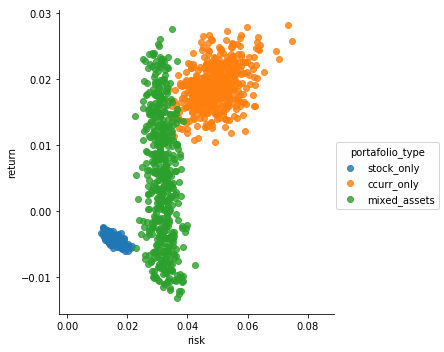

In [122]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

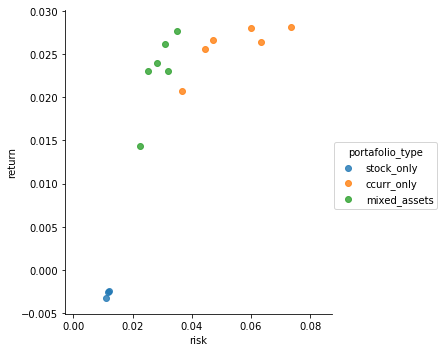

In [123]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [124]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
78,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",78,-0.003285,0.011133,"[0.165158537319, 0.0417281734572, 0.0429002360...",stock_only
22,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",22,-0.002550,0.011809,"[0.151839410781, 0.0193110795638, 0.0433406984...",stock_only
163,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",163,-0.002446,0.011962,"[0.0580925763641, 0.0162740809825, 0.106184193...",stock_only


*** Ratio of Sharpe ***

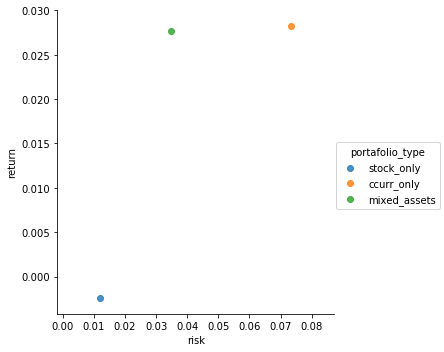

In [125]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Optimization with Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [136]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-2
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        return (return_portafolio / std_portafolio,) 
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return top10,pop, log, stats


############ Outputs processing ##############

def get_portafolio_stats(df_input, resource_optimal_distr):    
    average_close_portafolio = df_input.mean()
    cov_portafolio = df_input.cov()
    optimal_distr = resource_optimal_distr
    optimal_percentuals = np.divide(optimal_distr, sum(optimal_distr))
    return_in_percent = average_close_portafolio.dot(optimal_percentuals)
    risk_in_percent = cov_portafolio.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, resource_optimal_distr


## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [137]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    
    # Stock only
    top10_stock, pop_stock, log_stock, stas_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_stocks_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    top10_ccurr, pop_ccurr, log_ccurr, stas_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_cripto_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    top10, pop, log, stas = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_returns_pd[tail - (lag + window_time): tail - lag], pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output, df_ga_ccur_output, df_ga_output

In [142]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, True)

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.282641	0.0277801	-0.389882	-0.156874
1  	606   	-0.254259	0.0324943	-0.36262 	-0.0826022
2  	605   	-0.226796	0.0400447	-0.45181 	-0.0250549
3  	607   	-0.197978	0.046553 	-0.433424	-0.00886039
4  	636   	-0.163872	0.0570721	-0.581589	0.0106954  
5  	603   	nan      	nan      	nan      	nan        


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	587   	nan      	nan      	nan      	nan        
7  	569   	nan      	nan      	nan      	nan        
8  	559   	-0.0561135	0.0774593	-0.452639	0.0255426  
9  	590   	nan       	nan      	nan      	nan        
10 	582   	nan       	nan      	nan      	nan        
11 	583   	nan       	nan      	nan      	nan        
12 	638   	nan       	nan      	nan      	nan        
13 	594   	nan       	nan      	nan      	nan        
14 	597   	nan       	nan      	nan      	nan        
15 	562   	nan       	nan      	nan      	nan        
16 	592   	nan       	nan      	nan      	nan        
17 	581   	nan       	nan      	nan      	nan        
18 	582   	nan       	nan      	nan      	nan        
19 	613   	nan       	nan      	nan      	nan        
20 	575   	nan       	nan      	nan      	nan        
21 	591   	nan       	nan      	nan      	nan        
22 	581   	nan       	nan      	nan      	nan        
23 	572   	nan       	nan      	nan      	nan        
24 	607   	nan       	nan     

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.393914	0.0681695	0.196603	0.607242
1  	602   	0.448092	0.0690458	0.134475	0.703416
2  	606   	0.491614	0.0726596	0.0937927	0.703416
3  	604   	0.530562	0.072795 	0.126579 	0.7343  
4  	577   	0.569147	0.0791412	0.0665986	0.726889
5  	612   	0.592187	0.0963608	0.0790264	0.777096
6  	612   	0.613738	0.105779 	0.122144 	0.77817 
7  	593   	0.639285	0.106027 	0.138195 	0.795019
8  	595   	0.660782	0.117389 	0.0855122	0.798358
9  	609   	0.681459	0.120798 	0.129023 	0.798358
10 	579   	0.694841	0.131121 	0.101969 	0.823445
11 	617   	0.703578	0.147019 	0.0287675	0.82724 
12 	614   	0.724604	0.139698 	0.0517691	0.842772
13 	584   	0.724625	0.150684 	0.0934889	0.842772
14 	590   	0.734159	0.156842 	0.0110244	0.843383
15 	601   	0.736556	0.161455 	0.0695466	0.845772
16 	612   	0.752824	0.156448 	0.0830685	0.845772
17 	612   	0.756004	0.162339 	0.0407871	0.847689
18 	567   	0.763005	0.16266  	0.0881996	0.850797
19 	600   	0.770527	0.1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std     	min      	max    
0  	1000  	0.175866	0.320561	-0.365119	1.17253
1  	550   	0.473307	0.382956	-0.444961	2.64136
2  	591   	0.768808	0.472465	-0.430823	2.85316
3  	613   	1.07176 	0.577243	-0.418334	6.09043
4  	628   	1.44108 	0.705367	-0.426355	5.61112
5  	637   	1.78131 	0.952535	-0.446083	7.11287
6  	593   	2.32313 	1.16622 	-0.433289	7.11287
7  	590   	2.88404 	1.37779 	-0.434275	9.42326
8  	585   	3.44808 	1.75452 	-0.433275	9.65162
9  	614   	4.23436 	2.32466 	-0.507842	20.9478
10 	616   	5.22434 	2.73579 	-0.419647	20.9331
11 	599   	6.47358 	5.26734 	-0.436219	131.205
12 	577   	8.07384 	7.25498 	-0.424877	131.205
13 	593   	10.217  	11.2777 	-0.464379	131.205
14 	628   	13.0527 	14.9847 	-0.480593	146.373
15 	637   	16.8773 	19.3007 	-0.472899	137.252
16 	598   	24.1362 	27.6565 	-0.461516	137.252
17 	627   	35.6073 	37.0728 	-0.461438	147.329
18 	569   	56.6581 	48.3904 	-0.510564	153.329
19 	624   	76.9276 	54.993  	-0.443538	153.329
20 	583   	99

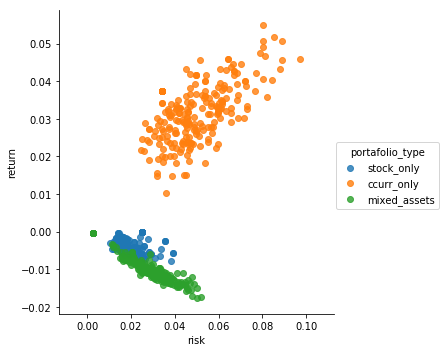

In [144]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

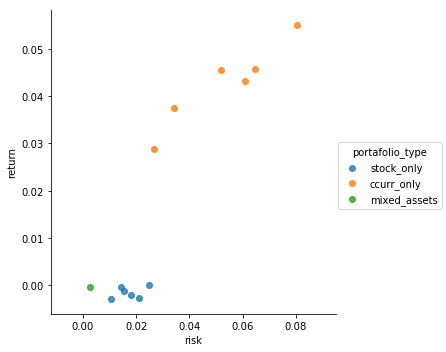

In [145]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
pre_fixed_time_window = 5
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [154]:
tempos = dict()
num_iterations = 2
pre_fixed_time_window = 30
# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size = 0

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

for i in range(0,num_iterations):
    print((num_iterations-i)*pre_fixed_time_window, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*pre_fixed_time_window, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

    tempos[(num_iterations-i)*pre_fixed_time_window] = dict()
    tempos[(num_iterations-i)*pre_fixed_time_window]['stock_frontier'] = ga_stock_frontier
    tempos[(num_iterations-i)*pre_fixed_time_window]['ccur_frontier'] = ga_ccur_frontier
    tempos[(num_iterations-i)*pre_fixed_time_window]['mixed_frontier'] = ga_mixed_frontier

60 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive

gen	nevals	avg      	std      	min      	max     
0  	1000  	-0.045176	0.0611693	-0.213968	0.118895
1  	567   	0.00576393	0.0555286	-0.267192	0.184732
2  	578   	0.0468287 	0.0566385	-0.357988	0.243587
3  	588   	0.0822173 	0.0611673	-0.321801	0.295231
4  	599   	0.107596  	0.0723885	-0.3489  	0.294751
5  	597   	0.140089  	0.0812813	-0.361398	0.29525 
6  	614   	0.17118   	0.087689 	-0.324337	0.317059
7  	649   	0.197252  	0.10034  	-0.350731	0.32263 
8  	602   	0.219367  	0.109036 	-0.358368	0.32263 
9  	586   	0.238269  	0.104134 	-0.312761	0.32286 
10 	625   	0.242161  	0.1198   	-0.359778	0.32263 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


11 	611   	nan       	nan      	nan      	nan     
12 	639   	nan       	nan      	nan      	nan     
13 	598   	0.265529  	0.115725 	-0.269413	0.324853
14 	660   	nan       	nan      	nan      	nan     
15 	574   	nan       	nan      	nan      	nan     
16 	614   	nan       	nan      	nan      	nan     
17 	592   	nan       	nan      	nan      	nan     
18 	573   	nan       	nan      	nan      	nan     
19 	602   	nan       	nan      	nan      	nan     
20 	585   	nan       	nan      	nan      	nan     
21 	627   	0.255647  	0.145749 	-0.340571	0.325376
22 	607   	0.245456  	0.1554   	-0.350732	0.325376
23 	584   	0.269023  	0.133902 	-0.282097	0.325376
24 	609   	0.257905  	0.145922 	-0.353098	0.325376
25 	564   	0.271243  	0.126647 	-0.298293	0.325376
26 	598   	0.260352  	0.14073  	-0.273141	0.325376
27 	621   	nan       	nan      	nan      	nan     
28 	600   	nan       	nan      	nan      	nan     
29 	616   	nan       	nan      	nan      	nan     
30 	597   	nan       	nan      

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.066149	0.0138373	-0.112049	-0.0224937
1  	636   	-0.0537241	0.0143092	-0.114478	0.0010904 
2  	615   	-0.0437337	0.0145037	-0.105774	0.00906012
3  	594   	-0.0333893	0.0153585	-0.15532 	0.0248946 
4  	579   	-0.0253203	0.0177255	-0.170918	0.0170855 
5  	626   	-0.0195106	0.0216411	-0.159985	0.0362054 
6  	607   	-0.0109195	0.0221651	-0.128965	0.0381888 
7  	584   	-0.0023475	0.0241465	-0.121327	0.0604531 
8  	615   	0.00303571	0.0311279	-0.158234	0.0604531 
9  	599   	0.0115115 	0.0314367	-0.13709 	0.0677095 
10 	641   	0.0146097 	0.0375979	-0.199044	0.0677095 
11 	579   	0.0234303 	0.0377385	-0.192465	0.0685706 
12 	610   	0.0260868 	0.0424043	-0.184389	0.0703756 
13 	603   	0.032109  	0.0429301	-0.160001	0.0703756 
14 	571   	0.0355159 	0.044602 	-0.132534	0.0703756 
15 	595   	0.0373401 	0.0480686	-0.184636	0.0703756 
16 	601   	nan       	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


17 	598   	nan       	nan      	nan      	nan       
18 	575   	nan       	nan      	nan      	nan       
19 	596   	nan       	nan      	nan      	nan       
20 	651   	0.0460482 	0.0514282	-0.202328	0.0703756 
21 	614   	0.0478423 	0.0500489	-0.197039	0.0703756 
22 	593   	nan       	nan      	nan      	nan       
23 	631   	nan       	nan      	nan      	nan       
24 	587   	nan       	nan      	nan      	nan       
25 	580   	0.0447679 	0.0534512	-0.170287	0.0703756 
26 	619   	nan       	nan      	nan      	nan       
27 	608   	nan       	nan      	nan      	nan       
28 	606   	nan       	nan      	nan      	nan       
29 	618   	nan       	nan      	nan      	nan       
30 	590   	nan       	nan      	nan      	nan       
31 	622   	nan       	nan      	nan      	nan       
32 	602   	nan       	nan      	nan      	nan       
33 	560   	nan       	nan      	nan      	nan       
34 	586   	nan       	nan      	nan      	nan       
35 	606   	0.0445095 	0.0515538	-0.175062	0.07

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std     	min      	max       
0  	1000  	-0.141478	0.028967	-0.234883	-0.0569281
1  	561   	-0.117908	0.0296817	-0.255788	0.0335756 
2  	604   	-0.095962	0.0305535	-0.216778	0.0335756 
3  	616   	-0.0754918	0.0342596	-0.227008	0.064578  
4  	628   	-0.0568928	0.0404454	-0.331034	0.0772427 
5  	593   	-0.0386398	0.0417928	-0.257738	0.0955699 
6  	609   	-0.0189625	0.0447115	-0.229104	0.127158  
7  	599   	-0.00556571	0.0550853	-0.243949	0.152796  
8  	623   	0.0106975  	0.0625273	-0.253272	0.154466  
9  	611   	0.0274815  	0.0691045	-0.277775	0.175702  
10 	588   	0.0469342  	0.0705625	-0.268335	0.184608  
11 	599   	0.0558889  	0.0821341	-0.328545	0.185863  
12 	604   	0.0729799  	0.0837842	-0.249186	0.227718  
13 	589   	0.0843993  	0.0959872	-0.339089	0.227718  
14 	589   	0.0961532  	0.103849 	-0.296412	0.256745  
15 	590   	0.10607    	0.113123 	-0.295151	0.256745  
16 	604   	0.118794   	0.123032 	-0.320916	0.292127  
17 	618   	0.129514   	0.129757 	-0.35048 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0642484	0.0514996	-0.231606	0.0986011
1  	598   	-0.0204881	0.0531916	-0.239061	0.209994 
2  	573   	0.0166616 	0.0517822	-0.227409	0.195065 
3  	600   	0.0523655 	0.0586382	-0.185883	0.322163 
4  	620   	0.0832087 	0.071912 	-0.29579 	0.340116 
5  	574   	0.11675   	0.0800484	-0.266145	0.340116 
6  	621   	0.14627   	0.0919292	-0.259539	0.340116 
7  	606   	0.174904  	0.102136 	-0.263576	0.340116 
8  	642   	0.192692  	0.11988  	-0.319563	0.340116 
9  	593   	0.225944  	0.125074 	-0.271643	0.340116 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


10 	612   	nan       	nan      	nan      	nan      
11 	603   	0.259423  	0.140835 	-0.327667	0.340272 
12 	620   	nan       	nan      	nan      	nan      
13 	595   	nan       	nan      	nan      	nan      
14 	604   	nan       	nan      	nan      	nan      
15 	607   	nan       	nan      	nan      	nan      
16 	596   	nan       	nan      	nan      	nan      
17 	597   	nan       	nan      	nan      	nan      
18 	615   	nan       	nan      	nan      	nan      
19 	612   	nan       	nan      	nan      	nan      
20 	586   	nan       	nan      	nan      	nan      
21 	574   	nan       	nan      	nan      	nan      
22 	604   	nan       	nan      	nan      	nan      
23 	610   	nan       	nan      	nan      	nan      
24 	587   	nan       	nan      	nan      	nan      
25 	564   	nan       	nan      	nan      	nan      
26 	560   	nan       	nan      	nan      	nan      
27 	572   	nan       	nan      	nan      	nan      
28 	616   	nan       	nan      	nan      	nan      
29 	597   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.151695	0.0308441	-0.219923	-0.0185133
1  	591   	-0.120833	0.0363031	-0.218805	0.243421  
2  	642   	-0.0891855	0.044199 	-0.205535	0.243421  
3  	604   	-0.0560583	0.0526376	-0.242039	0.243421  
4  	618   	-0.0203252	0.0623917	-0.225105	0.253305  
5  	582   	0.0126518 	0.0785657	-0.219223	0.374815  
6  	565   	0.0533697 	0.0942803	-0.245393	0.40241   
7  	608   	0.0946425 	0.106662 	-0.223318	0.422285  
8  	631   	0.139991  	0.124346 	-0.204639	0.422285  
9  	612   	0.181543  	0.140983 	-0.22256 	0.422285  
10 	599   	0.227     	0.15633  	-0.248141	0.422285  
11 	595   	0.264194  	0.172419 	-0.219828	0.422285  
12 	619   	0.294963  	0.180636 	-0.229451	0.422285  
13 	571   	0.31624   	0.18153  	-0.23397 	0.422313  
14 	617   	0.318297  	0.191951 	-0.249926	0.422313  
15 	589   	0.320733  	0.194736 	-0.251805	0.422285  
16 	564   	0.328787  	0.191478 	-0.23256 	0.422285  
17 	581   	0.329972  	0.193328 	-0.245245	0.42228

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


33 	596   	0.32958   	0.189983 	-0.223157	0.422285  
34 	627   	0.310749  	0.206204 	-0.221779	0.422285  
35 	588   	nan       	nan      	nan      	nan       
36 	618   	nan       	nan      	nan      	nan       
37 	618   	0.316684  	0.203864 	-0.243175	0.422285  
38 	596   	0.323736  	0.19857  	-0.232431	0.422285  
39 	578   	0.326201  	0.195831 	-0.234196	0.422285  
40 	633   	0.314439  	0.203201 	-0.249926	0.422285  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.163654	0.0237196	0.0771124	0.234175
1  	571   	0.183141	0.0234028	0.058672 	0.283658
2  	618   	0.200106	0.0259565	0.0340557	0.2974  
3  	587   	0.21501 	0.0299307	0.0624272	0.2974  
4  	600   	0.232958	0.0300052	0.0556309	0.298953
5  	566   	0.24873 	0.0317838	0.087856 	0.336393
6  	592   	0.26052 	0.0358819	0.0626695	0.336393
7  	616   	0.268178	0.0411973	0.0455216	0.385774
8  	613   	0.279241	0.0425285	-0.0285879	0.385774
9  	623   	0.28533 	0.0480301	0.0364559 	0.36462 
10 	593   	0.29352 	0.0499706	0.0682754 	0.36547 
11 	554   	0.303283	0.0528633	0.0094133 	0.368137
12 	608   	0.311645	0.0536987	0.0733462 	0.377134
13 	604   	0.317625	0.0598258	0.0428965 	0.379401
14 	601   	0.323831	0.0650307	-0.014211 	0.384918
15 	648   	0.325092	0.0714238	-0.0742215	0.391503
16 	588   	0.330175	0.0725996	-0.011585 	0.391503
17 	583   	0.33588 	0.0751999	0.0113128 	0.392487
18 	622   	0.344828	0.0715727	0.0474018 	0.401047
19 	568  

In [155]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

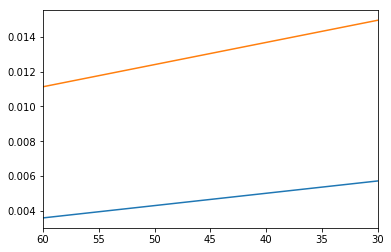

In [156]:
stock_ts['return'].plot()
stock_ts['risk'].plot()

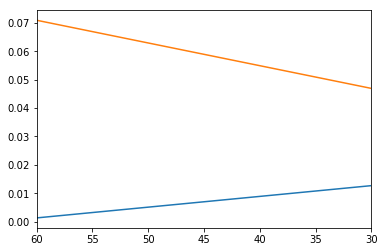

In [157]:
ccur_ts['return'].plot()
ccur_ts['risk'].plot()

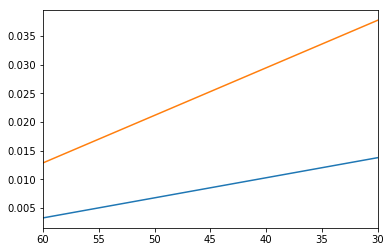

In [160]:
mixed_ts['return'].plot()
mixed_ts['risk'].plot()

In [631]:
# Calcular el VaR como medida interesante y mas fiable de los retornos
# Graficar el plot de las combinaciones de todos las combinaciones de las carteras

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***



In [161]:
mixed_ts

,return,risk,weights,portafolio_type,ratio_of_sharpe
60,0.003277,0.012862,"[0.512905816945, 0.0, 0.0, 0.385172896114, 0.0...",mixed_assets,-1.586674
30,0.013778,0.037731,"[0.0, 0.0, 0.0, 0.0, 0.331084457904, 0.0, 0.0,...",mixed_assets,-0.683213


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [632]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

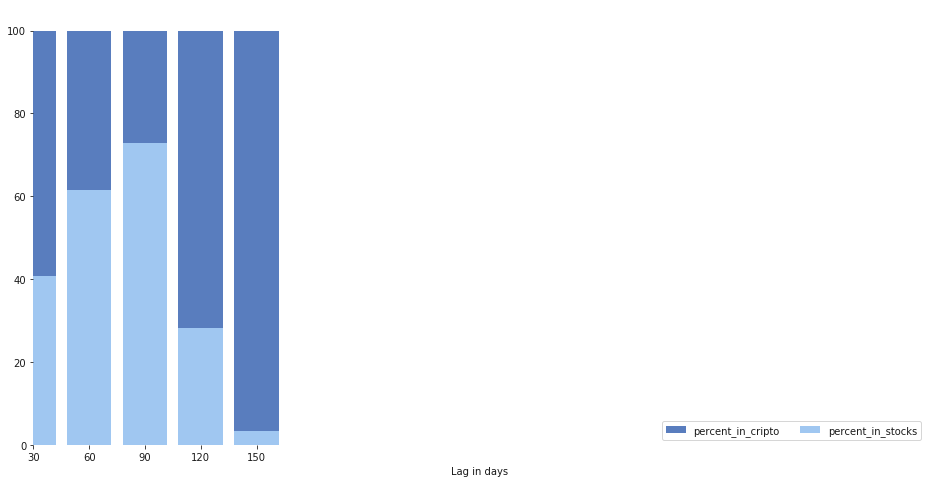

In [633]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Lag in days")
sns.despine(left=True, bottom=True)

In [634]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
150,0.012855,0.045616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032...",mixed_assets,-0.249399,3.230175,96.769825
120,0.049416,0.095202,"[0.0, 0.0, 0.109338355367, 0.0, 0.0, 0.1488134...",mixed_assets,-0.379809,28.252366,71.747634
90,0.004382,0.035520,"[0.135076513561, 0.135076513561, 0.0, 0.0, 0.0...",mixed_assets,-0.884798,72.984697,27.015303
60,0.004722,0.028266,"[0.335763435359, 0.0, 0.0, 0.280078517722, 0.0...",mixed_assets,-0.738469,61.584195,38.415805
30,0.012323,0.046801,"[0.204504213743, 0.0, 0.0, 0.0, 0.202093331283...",mixed_assets,-0.409423,40.659755,59.340245


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [X]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.